In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
import gc
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
import os
gc.enable()

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import statsmodels.api as sm
import pylab as plt
from scipy import stats

%pylab inline

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
it = 10
os.makedirs('/content/drive/My Drive/Colab Notebooks/Diplom/models/laser/{0}'.format(it))

# Laser для последовательностей товаров

###Собираем эмбеддинги продуктов

In [ ]:
!pip install laserembeddings

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 860kB 7.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=bfafd3d4866336c5c9e6eeee03a5af160782398d313381e2bf49b6061c9e9112
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [ ]:
!python -m laserembeddings download-models


✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!


In [ ]:
from laserembeddings import Laser

In [ ]:
products = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/products.csv')

In [ ]:
laser = Laser()

laser_embeddings = {}

for ind in tqdm(products.index, position=0):
  laser_embeddings[products.loc[ind, 'product_id']] = laser.embed_sentences(products.loc[ind, 'product_name'], lang='en')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/laser/laser_embeddings.pkl', 'wb') as f:
  pkl.dump(laser_embeddings, f)

100%|██████████| 49688/49688 [31:35<00:00, 26.21it/s]


###Считываем данные и подготавливаем выборку

In [ ]:
order_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/order_features.csv')
order_features['prod_seq'] = order_features['prod_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_seq'] = order_features['prev_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))

train_positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_positive.csv')
train_negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_negative.csv')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/id_to_token.pkl', 'rb') as f:
  id_to_token = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/token_to_id.pkl', 'rb') as f:
  token_to_id = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/val_orders.pkl', 'rb') as f:
  val_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/test_orders.pkl', 'rb') as f:
  test_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/laser/laser_embeddings.pkl', 'rb') as f:
  laser_embeddings = pkl.load(f)

###Понижаем размерность векторов laser

In [ ]:
pos_neg = pd.concat((train_positive, train_negative), axis=0)

In [ ]:
data_train = pos_neg[(~pos_neg['order_id'].isin(val_orders)) & (~pos_neg['order_id'].isin(test_orders))].sample(frac=1).drop_duplicates(subset=['uxp_total_bought', 'uxp_reorder_ratio',
       'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases', 'p_reorder_ratio', 'order_dow',
        'order_hour_of_day', 'days_since_prior_order'])
data_val = pos_neg[pos_neg['order_id'].isin(val_orders)].sample(frac=1)
data_test = pos_neg[pos_neg['order_id'].isin(test_orders)].sample(frac=1)

In [ ]:
laser_matrix = np.zeros((len(id_to_token), 1024))
for i_d, token in id_to_token.items():
  laser_matrix[i_d, :] = laser_embeddings[token]

In [ ]:
pca = PCA(n_components=13, random_state=432)

laser_matrix_red = pca.fit_transform(laser_matrix)

In [ ]:
laser_to_df = np.zeros((laser_matrix_red.shape[0], laser_matrix_red.shape[1] + 1))
for i_d, token in id_to_token.items():
  laser_to_df[i_d, 0] = token
  laser_to_df[i_d, 1:] = laser_matrix_red[i_d, :]

In [ ]:
laser_df = pd.DataFrame(laser_to_df, columns=['product_id', '0', '1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10', '11', '12'])

###Собираем новый датасет для бустинга

In [ ]:
new_data_train = data_train.merge(laser_df, how='inner', on='product_id')
new_data_val = data_val.merge(laser_df, how='inner', on='product_id')
new_data_test = data_test.merge(laser_df, how='inner', on='product_id')

prods_df = train_positive.merge(laser_df, how='inner', on='product_id')

In [ ]:
new_data_train = new_data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_val_set = new_data_val[new_data_val['label'] == 1]
new_test_set = new_data_test[new_data_test['label'] == 1]

In [ ]:
best_params = {'colsample_bytree': 0.4,
 'eval_metric': 'logloss',
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

###Обучаем и проверяем качество на валидации

100%|██████████| 6605/6605 [05:11<00:00, 21.19it/s]




{1: 0.4810749432248297, 2: 0.4373580620741862, 3: 0.4030532424930594, 4: 0.3753343426696947, 5: 0.3536651526621092, 6: 0.3349242997728972, 7: 0.3191660358314539, 8: 0.3062726650084712, 9: 0.295223586027913, 10: 0.28561722720881394}
{1: 0.08714598516148936, 2: 0.14649272586453443, 3: 0.19375908508274953, 4: 0.23242111977051222, 5: 0.266969747370138, 6: 0.2974912765224261, 7: 0.3252506616825338, 8: 0.3507247578271425, 9: 0.3745237250369582, 10: 0.3957371868583889}


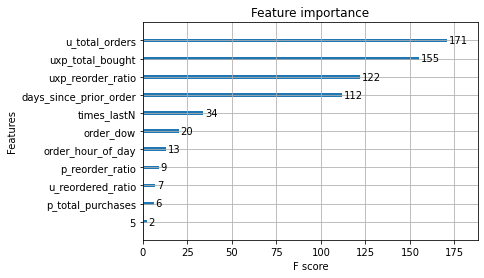

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

###Проверяем качество на тесте

100%|██████████| 6605/6605 [04:23<00:00, 25.11it/s]




{1: 0.456795889771135, 2: 0.4175618869687062, 3: 0.3872022419430241, 4: 0.36189475323057774, 5: 0.34239919040945743, 6: 0.32448855674917837, 7: 0.3110324503458632, 8: 0.3000162362936766, 9: 0.28981331969188556, 10: 0.28036498298524615}
{1: 0.0802565763155602, 2: 0.13615831987933777, 3: 0.18180599308105833, 4: 0.22056284370877724, 5: 0.25478647720326436, 6: 0.2836673285344936, 7: 0.3117818555865903, 8: 0.3387403959377382, 9: 0.36170959122177426, 10: 0.382299796298133}


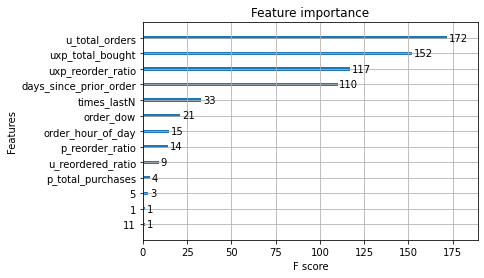

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_with_laser_feats = {}

metric_with_laser_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/laser/{0}/metric_with_laser_feats.pkl'.format(it), 'wb') as f:
  pkl.dump(metric_with_laser_feats, f)